In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

<ipython-input-17-83bc1a8e2213>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
<ipython-input-17-83bc1a8e2213>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


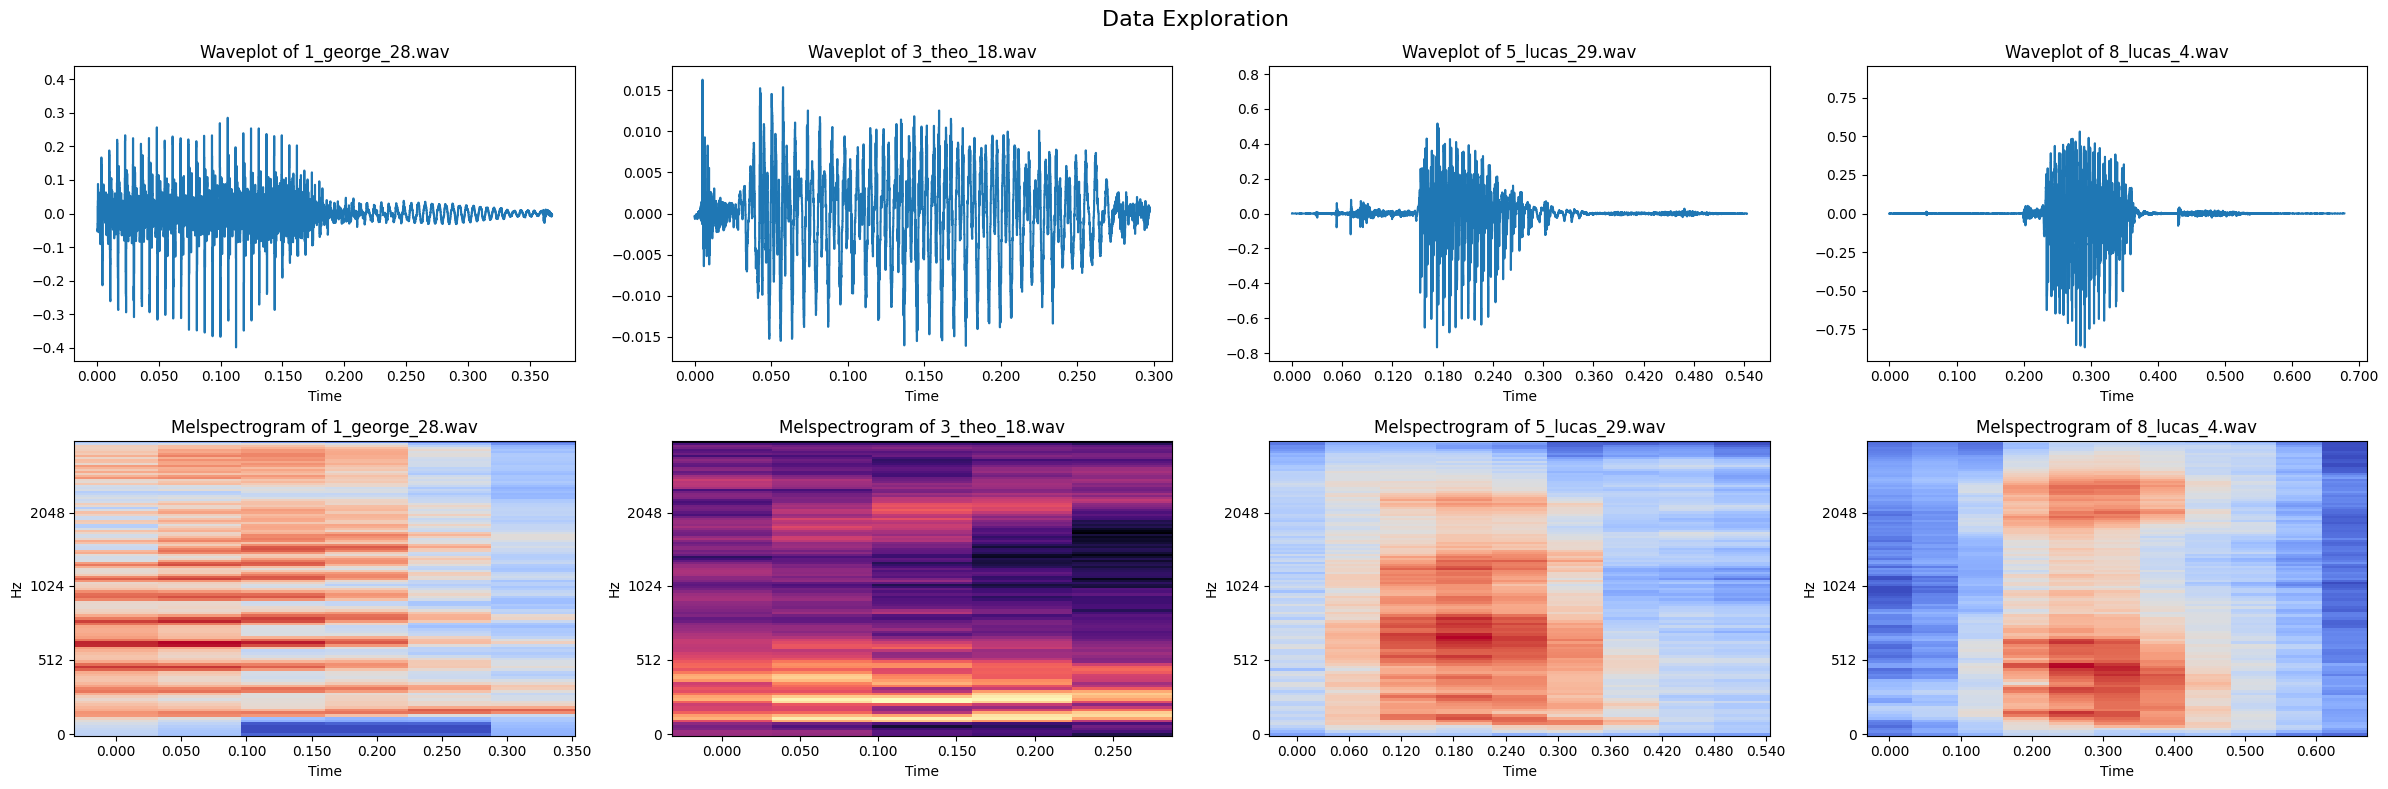

In [ ]:
visualize_digits = [1, 3, 5, 8]

description = pd.read_csv('/content/train.csv')
fig, axs = plt.subplots(nrows=2, ncols=(len(visualize_digits)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)
for i, digit in enumerate(visualize_digits):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['label'] == digit]['file_name'])
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('/content/drive/MyDrive/PROJECT/rec/recordings', rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(visualize_digits)])
    axs[i+len(visualize_digits)].set(title=f'Melspectrogram of {rand_file}')
plt.tight_layout()
plt.show()

In [ ]:
feature_list = []
label_list = []
# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('/content/drive/MyDrive/PROJECT/rec/recordings')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('/content/drive/MyDrive/PROJECT/rec/recordings', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    feature_list.append(mels_db.reshape((128, 16, 1)))
    label_list.append(file[0])
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


100%|██████████| 3020/3020 [02:30<00:00, 20.03it/s]


In [ ]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(10, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

NameError: ignored

Epoch 1/10
24/24 [==============================] - 3s 126ms/step - loss: 0.1913 - accuracy: 0.9473 - val_loss: 0.0912 - val_accuracy: 0.9732
Epoch 2/10
24/24 [==============================] - 3s 113ms/step - loss: 0.1589 - accuracy: 0.9520 - val_loss: 0.1436 - val_accuracy: 0.9528
Epoch 3/10
24/24 [==============================] - 3s 147ms/step - loss: 0.1413 - accuracy: 0.9520 - val_loss: 0.0815 - val_accuracy: 0.9780
Epoch 4/10
24/24 [==============================] - 3s 112ms/step - loss: 0.1075 - accuracy: 0.9635 - val_loss: 0.0680 - val_accuracy: 0.9811
Epoch 5/10
24/24 [==============================] - 2s 87ms/step - loss: 0.0631 - accuracy: 0.9797 - val_loss: 0.0727 - val_accuracy: 0.9780
Epoch 6/10
24/24 [==============================] - 2s 86ms/step - loss: 0.0408 - accuracy: 0.9919 - val_loss: 0.0533 - val_accuracy: 0.9874
Epoch 7/10
24/24 [==============================] - 3s 111ms/step - loss: 0.0437 - accuracy: 0.9844 - val_loss: 0.0621 - val_accuracy: 0.9858
Epoch 8/

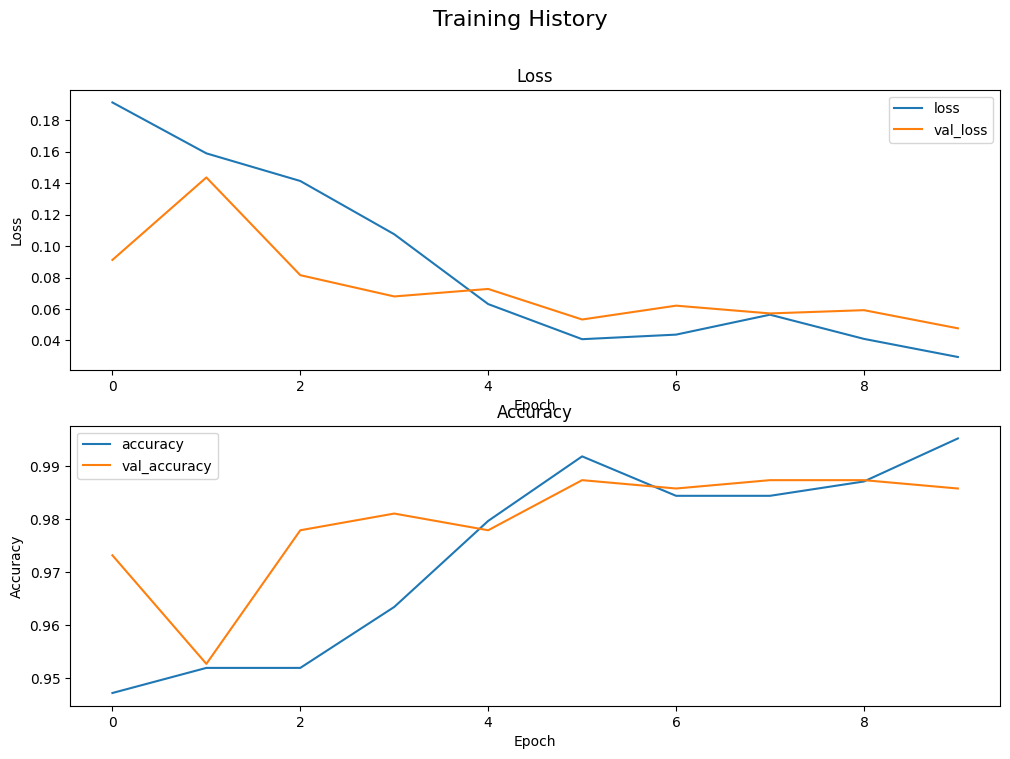

In [ ]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 10

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=10)
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

29/29 [==============================] - 1s 17ms/step


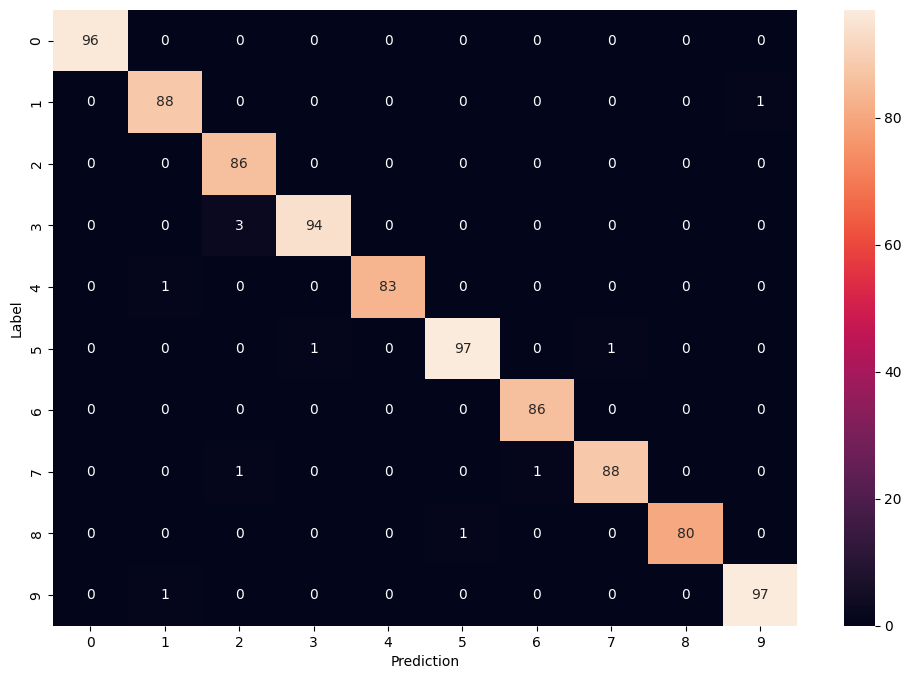

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
